In [1]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.read('challenge3.gwf', 'H1:CHALLENGE3')

In [2]:
import numpy as np
signal=np.array(data)
print(data)

TimeSeries([-3.04517369e-19, -3.35465069e-19, -3.35210566e-19,
            ...,  4.46471052e-19,  5.07624678e-19,
             4.98623016e-19]
           unit: ct,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE3,
           channel: H1:CHALLENGE3)


In [7]:
from pycbc.frame import read_frame

ts = read_frame("challenge3.gwf", "H1:CHALLENGE3")

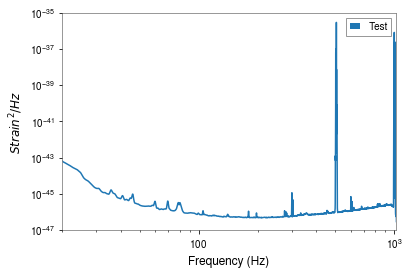

In [11]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

data = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

p = data.psd(2)
p = interpolate(p, data.delta_f)
p = inverse_spectrum_truncation(p, 2 * data.sample_rate, low_frequency_cutoff=15.0)
psd = p
    
pylab.plot(psd.sample_frequencies, psd, label='Test')

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-35)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

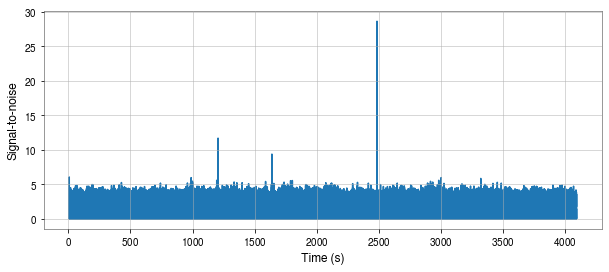

We found a signal at 2483.96875s with SNR 28.636095483197177


In [13]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=10, mass2=10, f_lower=20.0, delta_f=data.delta_f)

hp.resize(len(psd))

# For each observatory use this template to calculate the SNR time series
#snr = {}
snr = matched_filter(hp, data, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(5, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

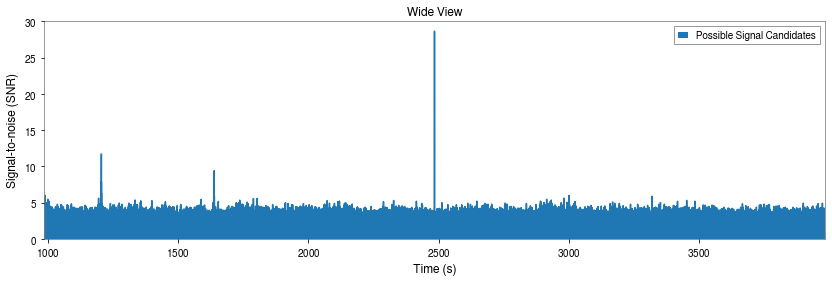

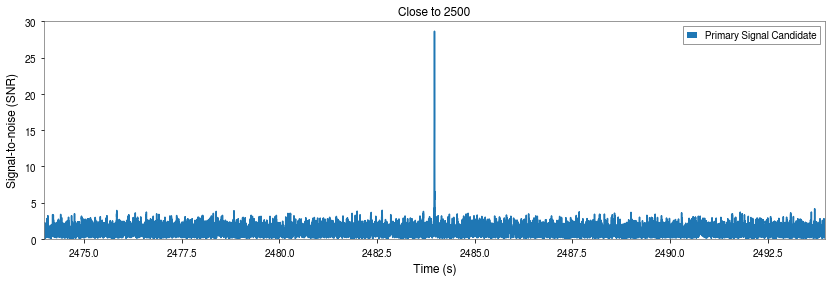

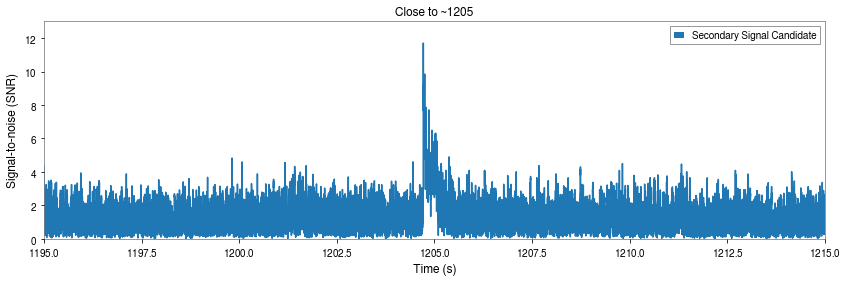

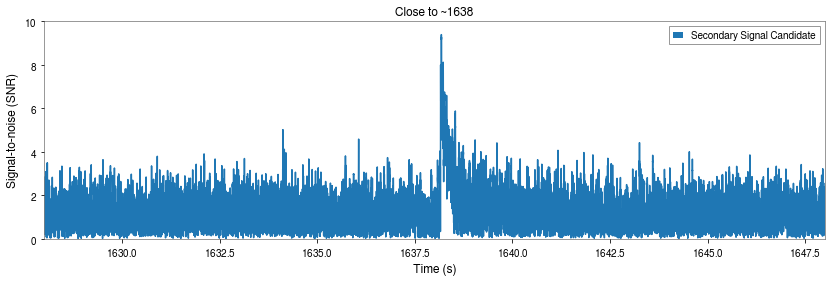

In [14]:
for w, title in [(1500, 'Wide View')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, abs(snr), label='Possible Signal Candidates')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(time - w, time + w)
    pylab.ylim(0, 30)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

for w, title in [(10, 'Close to 2500')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, abs(snr), label='Primary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(time - w, time + w)
    pylab.ylim(0, 30)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()    
    
for w, title in [(10, 'Close to ~1205')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, abs(snr), label='Secondary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(1205 - w, 1205 + w)
    pylab.ylim(0, 13)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()   
    
for w, title in [(10, 'Close to ~1638')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, abs(snr), label='Secondary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(1638 - w, 1638 + w)
    pylab.ylim(0, 10)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()      

In [15]:
from pycbc.vetoes import power_chisq

#chisq = {}

nbins = 26
chisq = power_chisq(hp, data, nbins, psd, low_frequency_cutoff=20.0)
chisq = chisq.crop(5, 4)
    
dof = nbins * 2 - 2
chisq /= dof

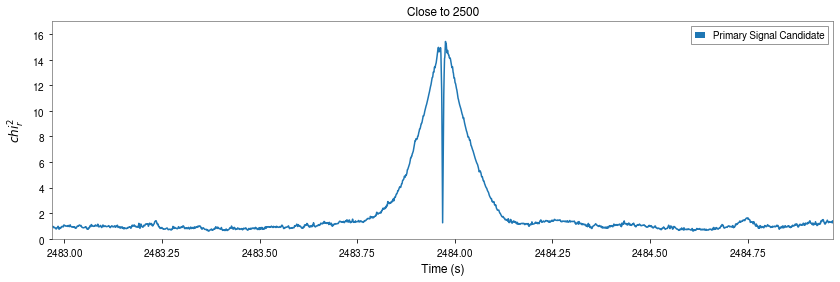

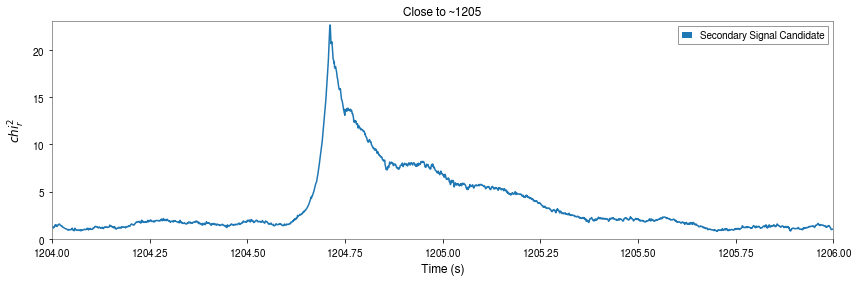

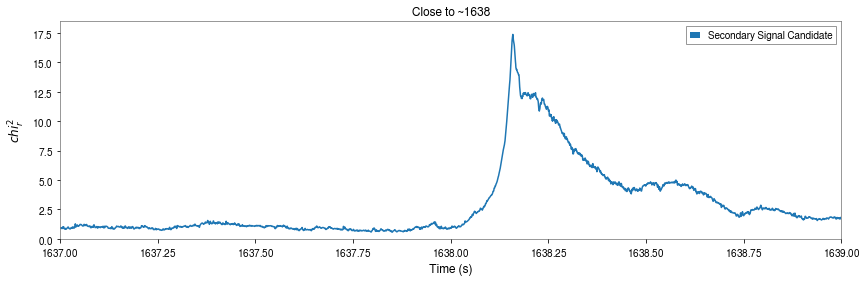

In [21]:
for w, title in [(1, 'Close to 2500')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(chisq.sample_times, chisq, label='Primary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(time - w, time + w)
    pylab.ylim(0, 17)
    pylab.xlabel('Time (s)')
    pylab.ylabel('$chi^2_r$')
    pylab.show()    
    
for w, title in [(1, 'Close to ~1205')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(chisq.sample_times, chisq, label='Secondary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(1205 - w, 1205 + w)
    pylab.ylim(0, 23)
    pylab.xlabel('Time (s)')
    pylab.ylabel('$chi^2_r$')
    pylab.show()   
    
for w, title in [(1, 'Close to ~1638')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(chisq.sample_times, chisq, label='Secondary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(1638 - w, 1638 + w)
    pylab.ylim(0, 18.5)
    pylab.xlabel('Time (s)')
    pylab.ylabel('$chi^2_r$')
    pylab.show()      

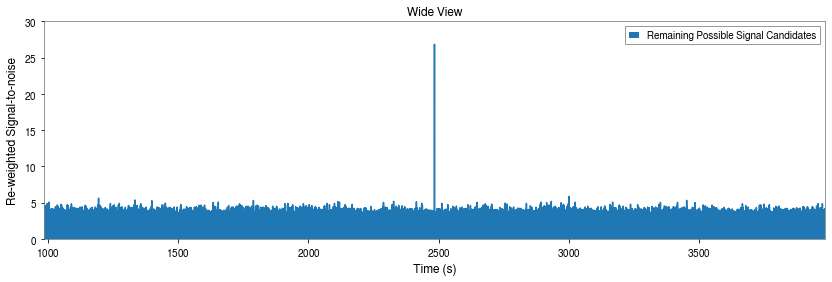

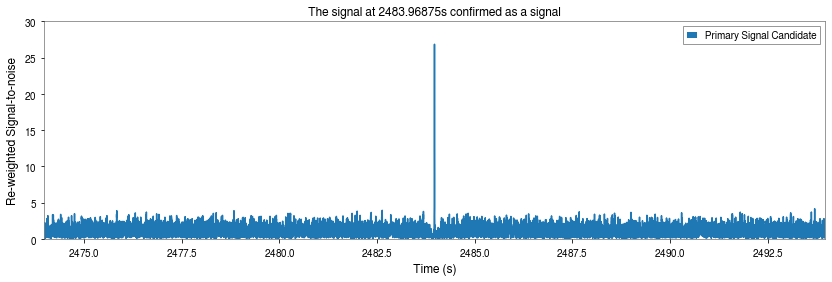

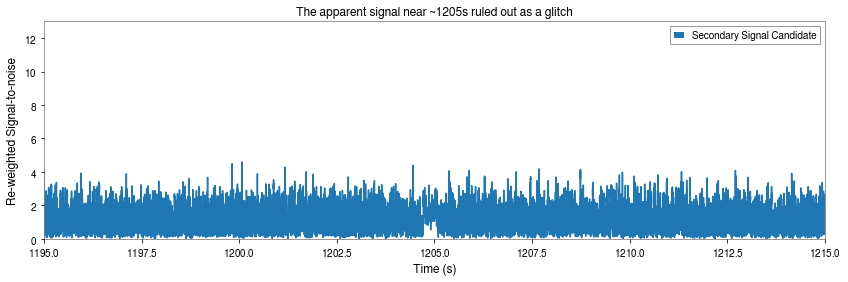

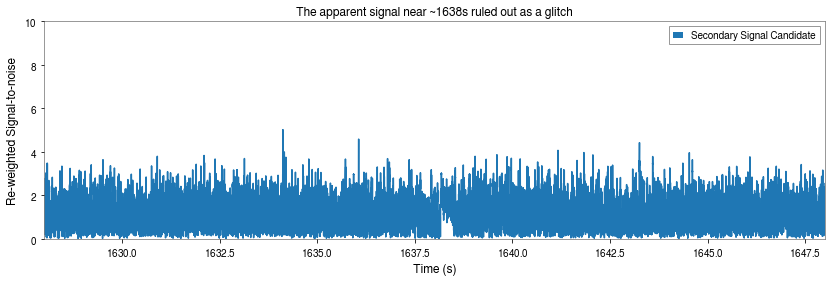

In [23]:
from pycbc.events.ranking import newsnr

nsnr = newsnr(abs(snr), chisq)

for w, title in [(1500, 'Wide View')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, nsnr, label='Remaining Possible Signal Candidates')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(time - w, time + w)
    pylab.ylim(0, 30)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()

for w, title in [(10, 'The signal at 2483.96875s confirmed as a signal')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, nsnr, label='Primary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(time - w, time + w)
    pylab.ylim(0, 30)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()    
    
for w, title in [(10, 'The apparent signal near ~1205s ruled out as a glitch')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, nsnr, label='Secondary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(1205 - w, 1205 + w)
    pylab.ylim(0, 13)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()   
    
for w, title in [(10, 'The apparent signal near ~1638s ruled out as a glitch')]:
    pylab.figure(figsize=[14, 4])
    pylab.plot(snr.sample_times, nsnr, label='Secondary Signal Candidate')

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(1638 - w, 1638 + w)
    pylab.ylim(0, 10)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()      

In [25]:
peak = nsnr.argmax()
snrp = nsnr[peak]
time = snr.sample_times[peak]
print("We found a signal at {}s with SNR {} after ruling out the other two candidates ruled out as glitches".format(time, 
                                                    abs(snrp)))

We found a signal at 2483.96875s with SNR 26.838946924035362 after ruling out the other two candidates ruled out as glitches
